In [26]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import random

In [28]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [29]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [30]:
tf.keras.backend.clear_session()

In [31]:
subject = 'Mato Grosso Do Sul - Consumo de Cimento (t)'
start_index = 0
split_index = 155

window_size = 36
train_split = split_index + 1 - 12

In [32]:
data = pd.read_csv('2003_mo_model_input_MS.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Mato Grosso Do Sul - Consumo de Cimento (t),Mato Grosso do Sul- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Mato Grosso do Sul - IDH,Mato Grosso Do Sul - Produção de Cimento (t),Mato Grosso do Sul - IDH Educacao,Mato Grosso do Sul - IDH Longevidade,Mato Grosso do Sul - Desemprego,Mato Grosso do Sul - value,Mato Grosso do Sul - PIB - Estadual,Mato Grosso do Sul - PIB - Construção Civil,Mato Grosso do Sul - PIB - Per Capita,Mato Grosso do Sul - PIB - Preços de Mercado,Mato Grosso do Sul - Depósito Poupança (R$),Mato Grosso do Sul - IDH Renda,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,33.744,10575.832000,3.127511,951.776390,1411.785524,24.741737,18.860002,72.032926,3.117091,0.741626,53.166560,0.670882,0.795565,8.248824,0.282837,4.562945e+07,2.151917e+06,16.203179,3.957545e+07,1.583944e+06,0.781096,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,32.230,10674.618538,3.124972,952.492950,1417.150685,24.087997,17.858746,70.442692,3.134253,0.741710,53.245714,0.671146,0.795878,8.242935,0.284487,4.568706e+07,2.153542e+06,16.206131,3.959155e+07,1.591665e+06,0.780750,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,33.559,10766.098168,2.985641,953.076971,1387.889369,23.538968,16.806765,68.403583,3.225807,0.741794,52.994640,0.671410,0.796192,8.237046,0.285379,4.574467e+07,2.155168e+06,16.209084,3.960765e+07,1.599385e+06,0.780403,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,34.283,10853.134597,2.615077,953.978721,1365.688397,22.897246,15.218196,64.880324,3.365984,0.741878,53.019283,0.671673,0.796506,8.231157,0.286089,4.580228e+07,2.156794e+06,16.212036,3.962375e+07,1.607106e+06,0.780057,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,36.066,10952.713907,2.488609,954.723605,1361.257638,22.059134,13.316197,61.056254,3.546947,0.741962,53.539593,0.671937,0.796820,8.225268,0.286122,4.585990e+07,2.158419e+06,16.214989,3.963985e+07,1.614826e+06,0.779710,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,2002-8,NaN,NaN,2.658799,953.010197,1389.843663,24.164653,14.249012,57.849305,4.247241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
257,2002-9,NaN,NaN,2.641716,952.337589,1442.950201,24.585985,15.370194,59.903115,4.169688,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
258,2002-10,NaN,NaN,2.858744,951.610669,1450.895260,25.150173,17.022021,63.836608,3.862138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
259,2002-11,NaN,NaN,2.964151,951.513490,1468.604568,25.132801,17.963946,67.311116,3.498752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


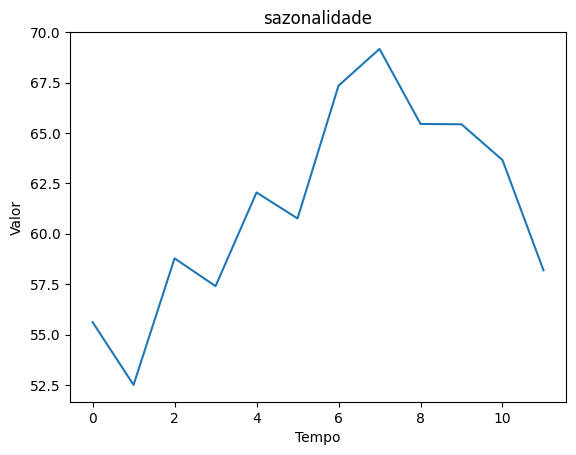

,sazonalidade
sazonalidade,
0,55.617041
1,52.501740
2,58.780685
3,57.401323
4,62.048338
5,60.757870
6,67.343295
7,69.167523
8,65.446161


In [33]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [34]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Mato Grosso do Sul- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Mato Grosso do Sul - IDH,Mato Grosso Do Sul - Produção de Cimento (t),Mato Grosso do Sul - IDH Educacao,Mato Grosso do Sul - IDH Longevidade,Mato Grosso do Sul - Desemprego,Mato Grosso do Sul - value,Mato Grosso do Sul - PIB - Estadual,Mato Grosso do Sul - PIB - Construção Civil,Mato Grosso do Sul - PIB - Per Capita,Mato Grosso do Sul - PIB - Preços de Mercado,Mato Grosso do Sul - Depósito Poupança (R$),Mato Grosso do Sul - IDH Renda,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Mato Grosso Do Sul - Consumo de Cimento (t)
0,2003-1,10575.832000,3.127511,951.776390,1411.785524,24.741737,18.860002,72.032926,3.117091,0.741626,53.166560,0.670882,0.795565,8.248824,0.282837,4.562945e+07,2.151917e+06,16.203179,3.957545e+07,1.583944e+06,0.781096,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,55.617041,33.744
1,2003-2,10674.618538,3.124972,952.492950,1417.150685,24.087997,17.858746,70.442692,3.134253,0.741710,53.245714,0.671146,0.795878,8.242935,0.284487,4.568706e+07,2.153542e+06,16.206131,3.959155e+07,1.591665e+06,0.780750,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,52.501740,32.230
2,2003-3,10766.098168,2.985641,953.076971,1387.889369,23.538968,16.806765,68.403583,3.225807,0.741794,52.994640,0.671410,0.796192,8.237046,0.285379,4.574467e+07,2.155168e+06,16.209084,3.960765e+07,1.599385e+06,0.780403,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,58.780685,33.559
3,2003-4,10853.134597,2.615077,953.978721,1365.688397,22.897246,15.218196,64.880324,3.365984,0.741878,53.019283,0.671673,0.796506,8.231157,0.286089,4.580228e+07,2.156794e+06,16.212036,3.962375e+07,1.607106e+06,0.780057,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,57.401323,34.283
4,2003-5,10952.713907,2.488609,954.723605,1361.257638,22.059134,13.316197,61.056254,3.546947,0.741962,53.539593,0.671937,0.796820,8.225268,0.286122,4.585990e+07,2.158419e+06,16.214989,3.963985e+07,1.614826e+06,0.779710,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,62.048338,36.066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,2002-8,NaN,2.658799,953.010197,1389.843663,24.164653,14.249012,57.849305,4.247241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.048338,NaN
257,2002-9,NaN,2.641716,952.337589,1442.950201,24.585985,15.370194,59.903115,4.169688,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.757870,NaN
258,2002-10,NaN,2.858744,951.610669,1450.895260,25.150173,17.022021,63.836608,3.862138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.343295,NaN
259,2002-11,NaN,2.964151,951.513490,1468.604568,25.132801,17.963946,67.311116,3.498752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [35]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      33.550
1      33.682
2      40.149
3      39.205
4      38.897
        ...  
256       NaN
257       NaN
258       NaN
259       NaN
260       NaN
Name: Mato Grosso Do Sul - Consumo de Cimento (t), Length: 261, dtype: float64

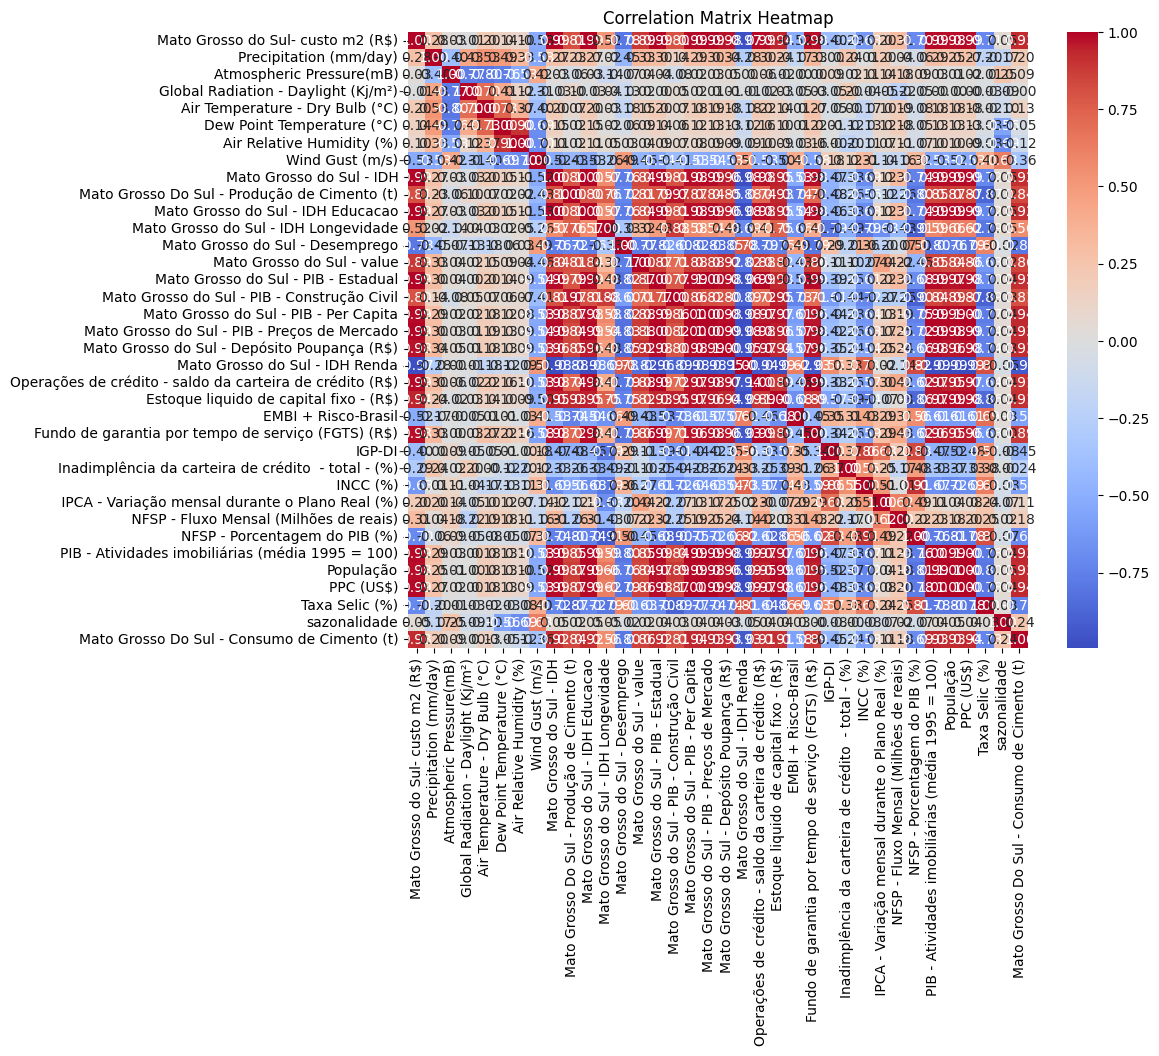

In [36]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [38]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Mato Grosso do Sul- custo m2 (R$),2.132988e+05
1,Precipitation (mm/day),7.388006e+00
2,Atmospheric Pressure(mB),6.254875e+01
3,Global Radiation - Daylight (Kj/m²),1.274731e+01
4,Air Temperature - Dry Bulb (°C),2.404435e+02
5,Dew Point Temperature (°C),1.140817e+03
6,Air Relative Humidity (%),6.518338e+02
7,Wind Gust (m/s),2.281162e+01
8,Mato Grosso do Sul - IDH,2.812563e+09
9,Mato Grosso Do Sul - Produção de Cimento (t),2.584806e+03


In [39]:
data = remove_high_vif_columns(safe_data, 1000000)
data

Num columns removed: 10


,Mato Grosso do Sul- custo m2 (R$),Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Mato Grosso Do Sul - Produção de Cimento (t),Mato Grosso do Sul - Desemprego,Mato Grosso do Sul - value,Mato Grosso do Sul - Depósito Poupança (R$),Mato Grosso do Sul - IDH Renda,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
0,10575.832000,3.127511,1411.785524,24.741737,18.860002,72.032926,3.117091,53.166560,8.248824,0.282837,1.583944e+06,0.781096,3.846831e+05,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,169.247665,1.611498,55.617041
1,10674.618538,3.124972,1417.150685,24.087997,17.858746,70.442692,3.134253,53.245714,8.242935,0.284487,1.591665e+06,0.780750,3.852662e+05,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,170.176810,1.450389,52.501740
2,10766.098168,2.985641,1387.889369,23.538968,16.806765,68.403583,3.225807,52.994640,8.237046,0.285379,1.599385e+06,0.780403,3.853051e+05,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,171.135713,1.870184,58.780685
3,10853.134597,2.615077,1365.688397,22.897246,15.218196,64.880324,3.365984,53.019283,8.231157,0.286089,1.607106e+06,0.780057,3.857521e+05,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,172.116904,1.355287,57.401323
4,10952.713907,2.488609,1361.257638,22.059134,13.316197,61.056254,3.546947,53.539593,8.225268,0.286122,1.614826e+06,0.779710,3.871640e+05,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,173.072271,1.585538,62.048338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,22044.824925,2.779372,1373.804347,24.516586,15.478281,61.472997,3.302433,67.875877,7.343183,0.341686,3.359717e+06,0.746175,3.143856e+06,336.843217,9.124085e+06,0.471500,3.103302,0.501878,0.527374,-1005.696691,2.438647,192.698092,390.589413,1.078474,69.167523
152,22129.202336,2.988203,1374.354443,24.818244,16.872476,65.153524,3.173143,67.532913,7.341129,0.339426,3.343254e+06,0.745431,3.159665e+06,345.939329,9.111628e+06,0.475422,3.177535,0.489257,0.525404,-1039.159506,2.375528,192.754385,391.798431,0.962516,65.446161
153,22217.070939,2.944321,1369.869788,25.021312,17.970291,68.201793,3.050174,66.846716,7.339075,0.337434,3.326791e+06,0.744687,3.177292e+06,356.198303,9.630300e+06,0.447600,3.254167,0.489071,0.522000,-1243.715598,2.307250,192.810678,393.032398,1.138989,65.430675
154,22307.306449,2.955002,1380.305629,25.145180,18.754108,70.593093,2.872230,66.193070,7.337021,0.335394,3.310328e+06,0.743943,3.192250e+06,363.318059,1.020613e+07,0.426394,3.330340,0.486059,0.509714,-1329.246736,2.242645,192.715004,394.326420,1.038436,63.654200


In [40]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
input_data

,Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Mato Grosso Do Sul - Produção de Cimento (t),Mato Grosso do Sul - Desemprego,Mato Grosso do Sul - value,Mato Grosso do Sul - Depósito Poupança (R$),Mato Grosso do Sul - IDH Renda,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,1.180812,0.096438,1.144325,1.454297,1.241054,-0.644936,-1.579767,1.018057,-0.351908,-1.314155,2.027895,-1.219223,-0.510608,-1.245444,3.807189,1.508986,3.557039,2.744724,0.791200,4.007134,-1.745295,-1.737578,2.007617
1,1.174571,0.166282,0.496753,0.955998,0.921907,-0.598850,-1.571363,1.007509,-0.317805,-1.303609,1.993533,-1.218580,-0.710802,-1.285329,3.466444,1.502979,3.362807,2.328463,0.796512,3.841816,-1.739636,-1.724415,1.464013
2,0.832236,-0.214643,-0.047096,0.432454,0.512673,-0.352982,-1.598020,0.996961,-0.299371,-1.293062,1.959170,-1.218537,-0.544025,-1.300726,3.304873,1.501477,3.234624,2.074077,0.748042,3.657082,-1.733978,-1.710831,2.880457
3,-0.078239,-0.503656,-0.682762,-0.358136,-0.194417,0.023463,-1.595404,0.986413,-0.284709,-1.282516,1.924808,-1.218044,-0.101360,-1.304485,3.047593,1.499141,3.111793,1.960720,0.637207,3.455390,-1.728320,-1.696931,1.143128
4,-0.388971,-0.561335,-1.512967,-1.304712,-0.961878,0.509435,-1.540160,0.975865,-0.284025,-1.271970,1.890446,-1.216487,0.484338,-1.295677,2.865728,1.487539,3.372081,1.810716,0.681319,3.226068,-1.721344,-1.683397,1.920025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,0.325435,-0.398002,0.921298,-0.228698,-0.878241,-0.147203,-0.018020,-0.604075,0.863938,1.111557,-1.434962,1.823582,0.414233,1.659621,-0.661498,-0.418507,-1.258759,0.318154,2.562832,-0.538499,1.326731,1.398025,0.209123
152,0.838532,-0.390841,1.220110,0.465157,-0.139588,-0.494411,-0.054434,-0.607754,0.817253,1.089068,-1.508735,1.841017,0.494098,1.654471,-0.630482,-0.159821,-1.388696,0.293838,2.549126,-0.570093,1.329342,1.415152,-0.182135
153,0.730714,-0.449222,1.421262,1.011511,0.472176,-0.824642,-0.127290,-0.611433,0.776088,1.066579,-1.582509,1.860456,0.584174,1.868895,-0.850517,0.107226,-1.390613,0.251845,2.465341,-0.604269,1.331953,1.432633,0.413308
154,0.756958,-0.313368,1.543961,1.401596,0.952091,-1.302508,-0.196691,-0.615111,0.733955,1.044090,-1.656282,1.876950,0.646687,2.106951,-1.018234,0.372672,-1.421626,0.100243,2.430308,-0.636606,1.327515,1.450965,0.074029


In [41]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Mato Grosso Do Sul - Produção de Cimento (t),Mato Grosso do Sul - Desemprego,Mato Grosso do Sul - value,Mato Grosso do Sul - Depósito Poupança (R$),Mato Grosso do Sul - IDH Renda,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,1.180812,0.096438,1.144325,1.454297,1.241054,-0.644936,-1.579767,1.018057,-0.351908,-1.314155,2.027895,-1.219223,-0.510608,-1.245444,3.807189,1.508986,3.557039,2.744724,0.791200,4.007134,-1.745295,-1.737578,2.007617
1,1.174571,0.166282,0.496753,0.955998,0.921907,-0.598850,-1.571363,1.007509,-0.317805,-1.303609,1.993533,-1.218580,-0.710802,-1.285329,3.466444,1.502979,3.362807,2.328463,0.796512,3.841816,-1.739636,-1.724415,1.464013
2,0.832236,-0.214643,-0.047096,0.432454,0.512673,-0.352982,-1.598020,0.996961,-0.299371,-1.293062,1.959170,-1.218537,-0.544025,-1.300726,3.304873,1.501477,3.234624,2.074077,0.748042,3.657082,-1.733978,-1.710831,2.880457
3,-0.078239,-0.503656,-0.682762,-0.358136,-0.194417,0.023463,-1.595404,0.986413,-0.284709,-1.282516,1.924808,-1.218044,-0.101360,-1.304485,3.047593,1.499141,3.111793,1.960720,0.637207,3.455390,-1.728320,-1.696931,1.143128
4,-0.388971,-0.561335,-1.512967,-1.304712,-0.961878,0.509435,-1.540160,0.975865,-0.284025,-1.271970,1.890446,-1.216487,0.484338,-1.295677,2.865728,1.487539,3.372081,1.810716,0.681319,3.226068,-1.721344,-1.683397,1.920025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,-0.861482,0.234390,0.630100,-0.595445,-1.208720,0.126479,0.570126,-0.787460,1.263682,1.392686,-0.970615,1.517172,-0.364905,1.409149,0.519146,-0.961354,-0.690123,1.744343,1.792831,-0.357756,1.345611,1.245801,-0.282621
140,-0.474204,0.377359,1.099279,0.052190,-0.582903,-0.170640,0.530657,-0.745632,1.247928,1.367944,-0.960202,1.549848,-0.347187,1.422197,0.540645,-1.047598,-0.646253,1.739673,1.807843,-0.353467,1.346023,1.254608,-0.612121
141,0.630327,0.873260,1.377531,0.483666,-0.165653,-0.644077,0.491109,-0.703805,1.228371,1.343203,-0.949788,1.588878,-0.321619,1.608476,0.589758,-1.189483,-0.641003,1.698689,1.374436,-0.355172,1.346436,1.263636,-0.137902
142,1.229915,0.671788,1.272322,1.058217,0.681035,-1.286240,0.451317,-0.661978,1.206420,1.318461,-0.939375,1.625721,-0.287493,1.830253,0.536404,-1.332682,-0.650191,1.675167,1.652790,-0.359681,1.337260,1.272935,-0.332143


In [42]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      33.550000
1      33.682000
2      40.149000
3      39.205000
4      38.897000
         ...    
139    88.200583
140    83.405836
141    82.967202
142    81.976767
143    76.347500
Name: Mato Grosso Do Sul - Consumo de Cimento (t), Length: 144, dtype: float64

In [43]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [44]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(108, 36, 23)

In [45]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Mato Grosso Do Sul - Produção de Cimento (t),Mato Grosso do Sul - Desemprego,Mato Grosso do Sul - value,Mato Grosso do Sul - Depósito Poupança (R$),Mato Grosso do Sul - IDH Renda,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
108,1.218190,1.379204,1.145568,0.873686,0.471012,-1.705029,1.267583,-2.364298,0.878581,0.767423,-0.758975,0.595959,-0.758140,0.735654,-0.150121,1.452528,-0.134638,-0.348558,-1.286705,-0.712725,0.693264,0.812014,-1.082183
109,1.353956,0.832432,0.677092,0.712044,0.543807,-1.558090,1.307668,-2.309829,0.904540,0.814478,-0.796112,0.621380,-0.744935,0.632719,-0.064049,1.577437,-0.250541,-0.314756,-1.091776,-0.707406,0.732176,0.831569,-1.036767
110,1.432426,-0.247366,-0.081992,0.433857,0.675347,-1.217742,1.306939,-2.255359,0.931223,0.861532,-0.833250,0.652999,-0.743509,0.633437,0.165323,1.665230,-0.253852,-0.193331,-1.072106,-0.699231,0.771088,0.850791,-0.752482
111,0.933731,-0.938483,-0.986127,-0.036647,0.586786,-0.883163,1.286514,-2.200890,0.957889,0.908586,-0.870387,0.685630,-0.748471,0.610450,0.155491,1.735648,-0.175858,-0.069191,-1.161345,-0.693507,0.810000,0.868783,-1.088413
112,-0.270605,-0.803825,-1.321673,-0.814751,-0.254350,-0.254284,1.277055,-2.146420,0.976111,0.955641,-0.907525,0.717515,-0.764308,0.631167,-0.075593,1.739412,0.099226,-0.104407,-0.961650,-0.679000,0.850727,0.886720,-1.508135
113,0.464691,-0.749186,-0.985691,-1.338701,-1.114551,0.303375,1.246336,-2.091950,0.998459,1.002695,-0.944662,0.747579,-0.786416,0.659533,-0.323610,1.747279,-0.153882,-0.083975,-0.938217,-0.662783,0.891455,0.905151,-1.474280
114,0.237796,-0.097973,-0.257627,-1.386036,-1.683752,0.531177,1.254620,-2.037481,1.021154,1.049749,-0.981800,0.775262,-0.808518,0.667761,-0.525659,1.756575,-0.146871,-0.089130,-0.921820,-0.650682,0.932183,0.923702,-1.463452
115,0.818146,0.413720,0.622581,-0.996097,-1.707429,0.531562,1.232796,-1.983011,1.043910,1.096804,-1.018937,0.805205,-0.838953,0.689072,-0.771574,1.787886,-0.265940,-0.124447,-0.813396,-0.648019,0.969967,0.942382,-1.236037
116,1.667060,0.744799,1.217253,-0.228611,-1.058640,0.049698,1.197244,-1.928542,1.065771,1.143858,-1.056075,0.836796,-0.869366,0.684945,-0.995926,1.740250,-0.285762,-0.077195,-0.692727,-0.640313,1.007752,0.960385,-0.935721
117,1.869504,1.382304,1.513775,0.531662,-0.300698,-0.460660,1.169644,-1.874072,1.085023,1.190912,-1.093213,0.876422,-0.900682,0.852584,-1.066619,1.618503,-0.293773,-0.110139,-0.644199,-0.639749,1.045536,0.977769,-1.241995


In [46]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 23)

In [47]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(72, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(36, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.1,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[3889396616, 3115229598, 2617136409, 1878044527, 274189963, 2694803005, 2835830190, 2690513629, 837057366, 11409809]


Step: 0 ___________________________________________
val_loss: 4.676028728485107
winner_seed: 3889396616


Step: 1 ___________________________________________
val_loss: 3.8500051498413086
winner_seed: 3115229598


Step: 2 ___________________________________________
val_loss: 6.922962665557861


Step: 3 ___________________________________________
val_loss: 6.396738052368164


Step: 4 ___________________________________________
val_loss: 4.153356552124023


Step: 5 ___________________________________________
val_loss: 7.118912220001221


Step: 6 ___________________________________________
val_loss: 4.258925437927246


Step: 7 ___________________________________________
val_loss: 3.8440287113189697
winner_seed: 2690513629


Step: 8 ___________________________________________
val_loss: 4.00663948059082


Step: 9 ___________________________________________
val_loss: 13.27238

In [51]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
4/4 [==============================] - 2s 114ms/step - loss: 5464.2837 - val_loss: 1460.3003
Epoch 2/10000
4/4 [==============================] - 0s 8ms/step - loss: 774.5700 - val_loss: 68.4896
Epoch 3/10000
4/4 [==============================] - 0s 8ms/step - loss: 152.1379 - val_loss: 145.2502
Epoch 4/10000
4/4 [==============================] - 0s 7ms/step - loss: 166.7284 - val_loss: 152.2945
Epoch 5/10000
4/4 [==============================] - 0s 8ms/step - loss: 159.8040 - val_loss: 35.0193
Epoch 6/10000
4/4 [==============================] - 0s 8ms/step - loss: 115.8816 - val_loss: 38.9020
Epoch 7/10000
4/4 [==============================] - 0s 7ms/step - loss: 84.8453 - val_loss: 62.1069
Epoch 8/10000
4/4 [==============================] - 0s 8ms/step - loss: 195.1767 - val_loss: 69.0749
Epoch 9/10000
4/4 [==============================] - 0s 7ms/step - loss: 117.4939 - val_loss: 28.5445
Epoch 10/10000
4/4 [==============================] - 0s 7ms/step - loss: 12

4/4 [==============================] - 0s 8ms/step - loss: 29.1901 - val_loss: 171.0191
Epoch 82/10000
4/4 [==============================] - 0s 7ms/step - loss: 47.0912 - val_loss: 23.2804
Epoch 83/10000
4/4 [==============================] - 0s 7ms/step - loss: 38.9810 - val_loss: 25.0383
Epoch 84/10000
4/4 [==============================] - 0s 8ms/step - loss: 28.4653 - val_loss: 32.6957
Epoch 85/10000
4/4 [==============================] - 0s 7ms/step - loss: 29.1421 - val_loss: 52.4570
Epoch 86/10000
4/4 [==============================] - 0s 8ms/step - loss: 21.6367 - val_loss: 34.7325
Epoch 87/10000
4/4 [==============================] - 0s 7ms/step - loss: 23.0922 - val_loss: 43.6940
Epoch 88/10000
4/4 [==============================] - 0s 7ms/step - loss: 25.7675 - val_loss: 90.8928
Epoch 89/10000
4/4 [==============================] - 0s 7ms/step - loss: 31.9664 - val_loss: 39.9406
Epoch 90/10000
4/4 [==============================] - 0s 7ms/step - loss: 24.4535 - val_loss: 76

Epoch 161/10000
4/4 [==============================] - 0s 7ms/step - loss: 22.9702 - val_loss: 100.2773
Epoch 162/10000
4/4 [==============================] - 0s 8ms/step - loss: 34.1786 - val_loss: 15.7263
Epoch 163/10000
4/4 [==============================] - 0s 8ms/step - loss: 23.6154 - val_loss: 27.9363
Epoch 164/10000
4/4 [==============================] - 0s 8ms/step - loss: 19.1490 - val_loss: 30.3323
Epoch 165/10000
4/4 [==============================] - 0s 7ms/step - loss: 19.1762 - val_loss: 23.3575
Epoch 166/10000
4/4 [==============================] - 0s 8ms/step - loss: 20.4180 - val_loss: 24.6947
Epoch 167/10000
4/4 [==============================] - 0s 7ms/step - loss: 18.5769 - val_loss: 26.1706
Epoch 168/10000
4/4 [==============================] - 0s 7ms/step - loss: 36.5612 - val_loss: 15.2892
Epoch 169/10000
4/4 [==============================] - 0s 8ms/step - loss: 21.4573 - val_loss: 28.9163
Epoch 170/10000
4/4 [==============================] - 0s 7ms/step - los

4/4 [==============================] - 0s 8ms/step - loss: 23.4580 - val_loss: 80.6964
Epoch 241/10000
4/4 [==============================] - 0s 7ms/step - loss: 27.5334 - val_loss: 35.6885
Epoch 242/10000
4/4 [==============================] - 0s 7ms/step - loss: 22.5312 - val_loss: 45.7555
Epoch 243/10000
4/4 [==============================] - 0s 8ms/step - loss: 21.3876 - val_loss: 24.0794
Epoch 244/10000
4/4 [==============================] - 0s 7ms/step - loss: 20.0522 - val_loss: 33.6725
Epoch 245/10000
4/4 [==============================] - 0s 8ms/step - loss: 21.2722 - val_loss: 19.5151
Epoch 246/10000
4/4 [==============================] - 0s 7ms/step - loss: 20.7765 - val_loss: 29.7303
Epoch 247/10000
4/4 [==============================] - 0s 8ms/step - loss: 21.0909 - val_loss: 76.8196
Epoch 248/10000
4/4 [==============================] - 0s 8ms/step - loss: 33.4138 - val_loss: 33.2006
Epoch 249/10000
4/4 [==============================] - 0s 7ms/step - loss: 20.7111 - val_

4/4 [==============================] - 0s 7ms/step - loss: 28.0439 - val_loss: 10.8575
Epoch 320/10000
4/4 [==============================] - 0s 7ms/step - loss: 29.9784 - val_loss: 32.1697
Epoch 321/10000
4/4 [==============================] - 0s 8ms/step - loss: 21.2460 - val_loss: 17.1454
Epoch 322/10000
4/4 [==============================] - 0s 7ms/step - loss: 19.7113 - val_loss: 74.3186
Epoch 323/10000
4/4 [==============================] - 0s 8ms/step - loss: 24.1304 - val_loss: 41.5917
Epoch 324/10000
4/4 [==============================] - 0s 7ms/step - loss: 19.9746 - val_loss: 24.0512
Epoch 325/10000
4/4 [==============================] - 0s 7ms/step - loss: 20.6141 - val_loss: 28.1567
Epoch 326/10000
4/4 [==============================] - 0s 8ms/step - loss: 18.8841 - val_loss: 39.5669
Epoch 327/10000
4/4 [==============================] - 0s 7ms/step - loss: 19.9366 - val_loss: 9.6383
Epoch 328/10000
4/4 [==============================] - 0s 8ms/step - loss: 30.8633 - val_l

4/4 [==============================] - 0s 7ms/step - loss: 16.2243 - val_loss: 11.1499
Epoch 399/10000
4/4 [==============================] - 0s 8ms/step - loss: 18.8983 - val_loss: 48.7775
Epoch 400/10000
4/4 [==============================] - 0s 7ms/step - loss: 22.1404 - val_loss: 31.7321
Epoch 401/10000
4/4 [==============================] - 0s 8ms/step - loss: 19.1789 - val_loss: 19.6307
Epoch 402/10000
4/4 [==============================] - 0s 7ms/step - loss: 15.0558 - val_loss: 22.0832
Epoch 403/10000
4/4 [==============================] - 0s 7ms/step - loss: 16.5697 - val_loss: 18.0240
Epoch 404/10000
4/4 [==============================] - 0s 8ms/step - loss: 17.5861 - val_loss: 17.0312
Epoch 405/10000
4/4 [==============================] - 0s 7ms/step - loss: 16.5332 - val_loss: 16.8078
Epoch 406/10000
4/4 [==============================] - 0s 8ms/step - loss: 16.8405 - val_loss: 15.9689
Epoch 407/10000
4/4 [==============================] - 0s 7ms/step - loss: 17.6916 - val_

4/4 [==============================] - 0s 8ms/step - loss: 17.4536 - val_loss: 33.1249
Epoch 478/10000
4/4 [==============================] - 0s 7ms/step - loss: 16.7107 - val_loss: 32.2685
Epoch 479/10000
4/4 [==============================] - 0s 8ms/step - loss: 16.9087 - val_loss: 28.9934
Epoch 480/10000
4/4 [==============================] - 0s 7ms/step - loss: 18.1503 - val_loss: 23.6375
Epoch 481/10000
4/4 [==============================] - 0s 7ms/step - loss: 15.2780 - val_loss: 26.9130
Epoch 482/10000
4/4 [==============================] - 0s 8ms/step - loss: 16.3451 - val_loss: 19.8177
Epoch 483/10000
4/4 [==============================] - 0s 7ms/step - loss: 16.0709 - val_loss: 23.4887
Epoch 484/10000
4/4 [==============================] - 0s 8ms/step - loss: 17.6462 - val_loss: 12.7757
Epoch 485/10000
4/4 [==============================] - 0s 7ms/step - loss: 15.5002 - val_loss: 15.7892
Epoch 486/10000
4/4 [==============================] - 0s 7ms/step - loss: 14.8832 - val_

4/4 [==============================] - 0s 8ms/step - loss: 14.1514 - val_loss: 15.9127
Epoch 557/10000
4/4 [==============================] - 0s 8ms/step - loss: 15.4126 - val_loss: 7.7699
Epoch 558/10000
4/4 [==============================] - 0s 7ms/step - loss: 24.7635 - val_loss: 12.6224
Epoch 559/10000
4/4 [==============================] - 0s 7ms/step - loss: 17.6260 - val_loss: 20.0059
Epoch 560/10000
4/4 [==============================] - 0s 7ms/step - loss: 17.9008 - val_loss: 25.5992
Epoch 561/10000
4/4 [==============================] - 0s 8ms/step - loss: 16.4776 - val_loss: 13.7041
Epoch 562/10000
4/4 [==============================] - 0s 7ms/step - loss: 16.5412 - val_loss: 19.6414
Epoch 563/10000
4/4 [==============================] - 0s 7ms/step - loss: 15.3536 - val_loss: 33.9514
Epoch 564/10000
4/4 [==============================] - 0s 7ms/step - loss: 17.1524 - val_loss: 15.1846
Epoch 565/10000
4/4 [==============================] - 0s 7ms/step - loss: 18.1233 - val_l

4/4 [==============================] - 0s 7ms/step - loss: 14.6691 - val_loss: 29.9353
Epoch 636/10000
4/4 [==============================] - 0s 8ms/step - loss: 14.7304 - val_loss: 38.2308
Epoch 637/10000
4/4 [==============================] - 0s 7ms/step - loss: 13.9894 - val_loss: 17.0420
Epoch 638/10000
4/4 [==============================] - 0s 7ms/step - loss: 15.2682 - val_loss: 26.9892
Epoch 639/10000
4/4 [==============================] - 0s 8ms/step - loss: 14.1080 - val_loss: 14.7446
Epoch 640/10000
4/4 [==============================] - 0s 7ms/step - loss: 17.9450 - val_loss: 18.1970
Epoch 641/10000
4/4 [==============================] - 0s 7ms/step - loss: 16.4994 - val_loss: 19.5507
Epoch 642/10000
4/4 [==============================] - 0s 8ms/step - loss: 20.9425 - val_loss: 57.0533
Epoch 643/10000
4/4 [==============================] - 0s 7ms/step - loss: 19.2007 - val_loss: 12.5049
Epoch 644/10000
4/4 [==============================] - 0s 8ms/step - loss: 18.4041 - val_

4/4 [==============================] - 0s 8ms/step - loss: 21.2923 - val_loss: 22.4898
Epoch 715/10000
4/4 [==============================] - 0s 9ms/step - loss: 16.9250 - val_loss: 26.8515
Epoch 716/10000
4/4 [==============================] - 0s 9ms/step - loss: 12.7433 - val_loss: 25.5490
Epoch 717/10000
4/4 [==============================] - 0s 8ms/step - loss: 14.9524 - val_loss: 27.0783
Epoch 718/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.7410 - val_loss: 27.4211
Epoch 719/10000
4/4 [==============================] - 0s 8ms/step - loss: 14.2145 - val_loss: 29.9590
Epoch 720/10000
4/4 [==============================] - 0s 8ms/step - loss: 13.1069 - val_loss: 20.9556
Epoch 721/10000
4/4 [==============================] - 0s 8ms/step - loss: 14.4604 - val_loss: 44.6200
Epoch 722/10000
4/4 [==============================] - 0s 8ms/step - loss: 16.3070 - val_loss: 10.9966
Epoch 723/10000
4/4 [==============================] - 0s 8ms/step - loss: 19.2761 - val_

4/4 [==============================] - 0s 7ms/step - loss: 14.4867 - val_loss: 26.7529
Epoch 794/10000
4/4 [==============================] - 0s 8ms/step - loss: 14.9911 - val_loss: 32.0009
Epoch 795/10000
4/4 [==============================] - 0s 7ms/step - loss: 12.8769 - val_loss: 34.2327
Epoch 796/10000
4/4 [==============================] - 0s 8ms/step - loss: 13.5481 - val_loss: 42.2831
Epoch 797/10000
4/4 [==============================] - 0s 7ms/step - loss: 14.7254 - val_loss: 26.2595
Epoch 798/10000
4/4 [==============================] - 0s 7ms/step - loss: 12.7193 - val_loss: 13.0561
Epoch 799/10000
4/4 [==============================] - 0s 7ms/step - loss: 14.4836 - val_loss: 48.5822
Epoch 800/10000
4/4 [==============================] - 0s 7ms/step - loss: 15.2865 - val_loss: 35.6383
Epoch 801/10000
4/4 [==============================] - 0s 8ms/step - loss: 13.0827 - val_loss: 11.6852
Epoch 802/10000
4/4 [==============================] - 0s 7ms/step - loss: 17.7823 - val_

4/4 [==============================] - 0s 7ms/step - loss: 13.8787 - val_loss: 85.0988
Epoch 873/10000
4/4 [==============================] - 0s 7ms/step - loss: 20.0637 - val_loss: 39.4095
Epoch 874/10000
4/4 [==============================] - 0s 8ms/step - loss: 15.6901 - val_loss: 31.3197
Epoch 875/10000
4/4 [==============================] - 0s 7ms/step - loss: 14.0425 - val_loss: 22.8562
Epoch 876/10000
4/4 [==============================] - 0s 8ms/step - loss: 14.5861 - val_loss: 16.8115
Epoch 877/10000
4/4 [==============================] - 0s 7ms/step - loss: 16.1364 - val_loss: 36.8811
Epoch 878/10000
4/4 [==============================] - 0s 7ms/step - loss: 13.5677 - val_loss: 70.5387
Epoch 879/10000
4/4 [==============================] - 0s 7ms/step - loss: 18.3916 - val_loss: 36.7623
Epoch 880/10000
4/4 [==============================] - 0s 7ms/step - loss: 14.6762 - val_loss: 34.3615
Epoch 881/10000
4/4 [==============================] - 0s 8ms/step - loss: 13.3979 - val_

4/4 [==============================] - 0s 7ms/step - loss: 12.7870 - val_loss: 13.6408
Epoch 952/10000
4/4 [==============================] - 0s 7ms/step - loss: 17.6438 - val_loss: 86.9448
Epoch 953/10000
4/4 [==============================] - 0s 7ms/step - loss: 18.4266 - val_loss: 52.2411
Epoch 954/10000
4/4 [==============================] - 0s 7ms/step - loss: 13.6193 - val_loss: 35.2205
Epoch 955/10000
4/4 [==============================] - 0s 8ms/step - loss: 12.8451 - val_loss: 58.3536
Epoch 956/10000
4/4 [==============================] - 0s 7ms/step - loss: 13.6799 - val_loss: 30.5635
Epoch 957/10000
4/4 [==============================] - 0s 8ms/step - loss: 11.9672 - val_loss: 41.0616
Epoch 958/10000
4/4 [==============================] - 0s 7ms/step - loss: 13.7878 - val_loss: 21.7472
Epoch 959/10000
4/4 [==============================] - 0s 7ms/step - loss: 12.0588 - val_loss: 28.8897
Epoch 960/10000
4/4 [==============================] - 0s 7ms/step - loss: 13.2926 - val_

4/4 [==============================] - 0s 7ms/step - loss: 12.6386 - val_loss: 7.3039
Epoch 1031/10000
4/4 [==============================] - 0s 8ms/step - loss: 16.9804 - val_loss: 10.4935
Epoch 1032/10000
4/4 [==============================] - 0s 7ms/step - loss: 13.1813 - val_loss: 26.0164
Epoch 1033/10000
4/4 [==============================] - 0s 7ms/step - loss: 13.0236 - val_loss: 35.2803
Epoch 1034/10000
4/4 [==============================] - 0s 7ms/step - loss: 12.1649 - val_loss: 34.2693
Epoch 1035/10000
4/4 [==============================] - 0s 7ms/step - loss: 13.6349 - val_loss: 25.1745
Epoch 1036/10000
4/4 [==============================] - 0s 8ms/step - loss: 11.7219 - val_loss: 66.3190
Epoch 1037/10000
4/4 [==============================] - 0s 7ms/step - loss: 16.6395 - val_loss: 40.5120
Epoch 1038/10000
4/4 [==============================] - 0s 8ms/step - loss: 12.0728 - val_loss: 23.3682
Epoch 1039/10000
4/4 [==============================] - 0s 7ms/step - loss: 12.340

Epoch 1109/10000
4/4 [==============================] - 0s 7ms/step - loss: 16.3525 - val_loss: 23.7349
Epoch 1110/10000
4/4 [==============================] - 0s 7ms/step - loss: 15.2971 - val_loss: 19.5927
Epoch 1111/10000
4/4 [==============================] - 0s 8ms/step - loss: 14.0543 - val_loss: 18.5789
Epoch 1112/10000
4/4 [==============================] - 0s 7ms/step - loss: 15.0651 - val_loss: 20.7515
Epoch 1113/10000
4/4 [==============================] - 0s 7ms/step - loss: 15.8217 - val_loss: 18.3488
Epoch 1114/10000
4/4 [==============================] - 0s 7ms/step - loss: 14.7781 - val_loss: 15.6613
Epoch 1115/10000
4/4 [==============================] - 0s 7ms/step - loss: 12.9913 - val_loss: 11.1448
Epoch 1116/10000
4/4 [==============================] - 0s 8ms/step - loss: 13.5750 - val_loss: 12.8747
Epoch 1117/10000
4/4 [==============================] - 0s 7ms/step - loss: 13.2334 - val_loss: 19.6786
Epoch 1118/10000
4/4 [==============================] - 0s 8ms/s

Epoch 1188/10000
4/4 [==============================] - 0s 8ms/step - loss: 13.0856 - val_loss: 20.4716
Epoch 1189/10000
4/4 [==============================] - 0s 7ms/step - loss: 11.0109 - val_loss: 16.8864
Epoch 1190/10000
4/4 [==============================] - 0s 8ms/step - loss: 10.4818 - val_loss: 19.7735
Epoch 1191/10000
4/4 [==============================] - 0s 7ms/step - loss: 11.3509 - val_loss: 20.8287
Epoch 1192/10000
4/4 [==============================] - 0s 7ms/step - loss: 11.4597 - val_loss: 29.1638
Epoch 1193/10000
4/4 [==============================] - 0s 7ms/step - loss: 11.8271 - val_loss: 24.9594
Epoch 1194/10000
4/4 [==============================] - 0s 7ms/step - loss: 10.7766 - val_loss: 25.2539
Epoch 1195/10000
4/4 [==============================] - 0s 8ms/step - loss: 11.9892 - val_loss: 10.4339
Epoch 1196/10000
4/4 [==============================] - 0s 7ms/step - loss: 13.2564 - val_loss: 8.5179
Epoch 1197/10000
4/4 [==============================] - 0s 7ms/st

Epoch 1267/10000
4/4 [==============================] - 0s 7ms/step - loss: 10.7531 - val_loss: 30.8328
Epoch 1268/10000
4/4 [==============================] - 0s 8ms/step - loss: 10.7358 - val_loss: 22.5884
Epoch 1269/10000
4/4 [==============================] - 0s 7ms/step - loss: 11.0521 - val_loss: 20.3818
Epoch 1270/10000
4/4 [==============================] - 0s 7ms/step - loss: 11.8270 - val_loss: 26.2584
Epoch 1271/10000
4/4 [==============================] - 0s 7ms/step - loss: 10.2262 - val_loss: 21.6166
Epoch 1272/10000
4/4 [==============================] - 0s 7ms/step - loss: 9.5467 - val_loss: 14.9779
Epoch 1273/10000
4/4 [==============================] - 0s 8ms/step - loss: 9.7239 - val_loss: 31.3406
Epoch 1274/10000
4/4 [==============================] - 0s 7ms/step - loss: 12.2105 - val_loss: 15.7011
Epoch 1275/10000
4/4 [==============================] - 0s 8ms/step - loss: 12.2762 - val_loss: 19.9123
Epoch 1276/10000
4/4 [==============================] - 0s 7ms/ste

4/4 [==============================] - 0s 7ms/step - loss: 9.2370 - val_loss: 30.8864
Epoch 1347/10000
4/4 [==============================] - 0s 7ms/step - loss: 9.6240 - val_loss: 28.8977
Epoch 1348/10000
4/4 [==============================] - 0s 8ms/step - loss: 9.4745 - val_loss: 27.8805
Epoch 1349/10000
4/4 [==============================] - 0s 7ms/step - loss: 10.6432 - val_loss: 21.8300
Epoch 1350/10000
4/4 [==============================] - 0s 8ms/step - loss: 9.2968 - val_loss: 21.3965
Epoch 1351/10000
4/4 [==============================] - 0s 7ms/step - loss: 11.1603 - val_loss: 11.3499
Epoch 1352/10000
4/4 [==============================] - 0s 8ms/step - loss: 10.8187 - val_loss: 22.4166
Epoch 1353/10000
4/4 [==============================] - 0s 8ms/step - loss: 11.0312 - val_loss: 32.1943
Epoch 1354/10000
4/4 [==============================] - 0s 7ms/step - loss: 9.4734 - val_loss: 26.8029
Epoch 1355/10000
4/4 [==============================] - 0s 8ms/step - loss: 9.9363 - v

4/4 [==============================] - 0s 7ms/step - loss: 10.2786 - val_loss: 31.2773
Epoch 1426/10000
4/4 [==============================] - 0s 8ms/step - loss: 9.2814 - val_loss: 27.0753
Epoch 1427/10000
4/4 [==============================] - 0s 7ms/step - loss: 9.1359 - val_loss: 34.1493
Epoch 1428/10000
4/4 [==============================] - 0s 8ms/step - loss: 9.5638 - val_loss: 26.4244
Epoch 1429/10000
4/4 [==============================] - 0s 7ms/step - loss: 8.6631 - val_loss: 25.1278
Epoch 1430/10000
4/4 [==============================] - 0s 7ms/step - loss: 8.6251 - val_loss: 60.7436
Epoch 1431/10000
4/4 [==============================] - 0s 8ms/step - loss: 17.1228 - val_loss: 36.6368
Epoch 1432/10000
4/4 [==============================] - 0s 7ms/step - loss: 13.3096 - val_loss: 31.3730
Epoch 1433/10000
4/4 [==============================] - 0s 8ms/step - loss: 11.1875 - val_loss: 15.9581
Epoch 1434/10000
4/4 [==============================] - 0s 7ms/step - loss: 16.6438 - 

4/4 [==============================] - 0s 7ms/step - loss: 15.1116 - val_loss: 55.9586
Epoch 1505/10000
4/4 [==============================] - 0s 8ms/step - loss: 11.2393 - val_loss: 24.0480
Epoch 1506/10000
4/4 [==============================] - 0s 8ms/step - loss: 9.4788 - val_loss: 47.5047
Epoch 1507/10000
4/4 [==============================] - 0s 7ms/step - loss: 14.4794 - val_loss: 24.7027
Epoch 1508/10000
4/4 [==============================] - 0s 8ms/step - loss: 10.8672 - val_loss: 9.4375
Epoch 1509/10000
4/4 [==============================] - 0s 7ms/step - loss: 11.2125 - val_loss: 11.3548
Epoch 1510/10000
4/4 [==============================] - 0s 7ms/step - loss: 11.2862 - val_loss: 15.9129
Epoch 1511/10000
4/4 [==============================] - 0s 8ms/step - loss: 11.0407 - val_loss: 60.1251
Epoch 1512/10000
4/4 [==============================] - 0s 7ms/step - loss: 13.1483 - val_loss: 38.4703
Epoch 1513/10000
4/4 [==============================] - 0s 8ms/step - loss: 9.8042 

4/4 [==============================] - 0s 8ms/step - loss: 10.1741 - val_loss: 34.9317
Epoch 1584/10000
4/4 [==============================] - 0s 7ms/step - loss: 12.0498 - val_loss: 33.6195
Epoch 1585/10000
4/4 [==============================] - 0s 8ms/step - loss: 9.9547 - val_loss: 42.7800
Epoch 1586/10000
4/4 [==============================] - 0s 8ms/step - loss: 12.0468 - val_loss: 31.1551
Epoch 1587/10000
4/4 [==============================] - 0s 7ms/step - loss: 9.8600 - val_loss: 49.6069
Epoch 1588/10000
4/4 [==============================] - 0s 8ms/step - loss: 13.2693 - val_loss: 12.6702
Epoch 1589/10000
4/4 [==============================] - 0s 7ms/step - loss: 13.1284 - val_loss: 73.5452
Epoch 1590/10000
4/4 [==============================] - 0s 7ms/step - loss: 17.2692 - val_loss: 31.6447
Epoch 1591/10000
4/4 [==============================] - 0s 8ms/step - loss: 12.9024 - val_loss: 29.8194
Epoch 1592/10000
4/4 [==============================] - 0s 7ms/step - loss: 10.8943

4/4 [==============================] - 0s 7ms/step - loss: 9.2440 - val_loss: 74.7129
Epoch 1663/10000
4/4 [==============================] - 0s 8ms/step - loss: 28.5943 - val_loss: 24.2114
Epoch 1664/10000
4/4 [==============================] - 0s 7ms/step - loss: 10.3413 - val_loss: 24.7727
Epoch 1665/10000
4/4 [==============================] - 0s 7ms/step - loss: 9.0440 - val_loss: 23.1804
Epoch 1666/10000
4/4 [==============================] - 0s 8ms/step - loss: 9.9910 - val_loss: 27.6013
Epoch 1667/10000
4/4 [==============================] - 0s 7ms/step - loss: 9.4573 - val_loss: 24.1046
Epoch 1668/10000
4/4 [==============================] - 0s 8ms/step - loss: 8.9523 - val_loss: 24.7492
Epoch 1669/10000
4/4 [==============================] - 0s 7ms/step - loss: 9.1832 - val_loss: 23.9670
Epoch 1670/10000
4/4 [==============================] - 0s 7ms/step - loss: 8.3347 - val_loss: 24.2601
Epoch 1671/10000
4/4 [==============================] - 0s 7ms/step - loss: 8.5090 - val

4/4 [==============================] - 0s 7ms/step - loss: 8.3675 - val_loss: 24.6899
Epoch 1742/10000
4/4 [==============================] - 0s 7ms/step - loss: 8.0354 - val_loss: 24.6100
Epoch 1743/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.9938 - val_loss: 17.4903
Epoch 1744/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.5638 - val_loss: 36.9380
Epoch 1745/10000
4/4 [==============================] - 0s 8ms/step - loss: 8.1382 - val_loss: 11.5691
Epoch 1746/10000
4/4 [==============================] - 0s 7ms/step - loss: 9.3820 - val_loss: 26.3610
Epoch 1747/10000
4/4 [==============================] - 0s 8ms/step - loss: 8.4254 - val_loss: 24.0130
Epoch 1748/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.4942 - val_loss: 16.8822
Epoch 1749/10000
4/4 [==============================] - 0s 7ms/step - loss: 8.5254 - val_loss: 27.0336
Epoch 1750/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.6915 - val_l

4/4 [==============================] - 0s 7ms/step - loss: 7.2120 - val_loss: 31.5050
Epoch 1821/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.3956 - val_loss: 23.4020
Epoch 1822/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.0649 - val_loss: 39.3316
Epoch 1823/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.5932 - val_loss: 26.8487
Epoch 1824/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.8272 - val_loss: 16.2059
Epoch 1825/10000
4/4 [==============================] - 0s 7ms/step - loss: 8.2364 - val_loss: 17.8136
Epoch 1826/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.9549 - val_loss: 17.5511
Epoch 1827/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.7155 - val_loss: 26.8752
Epoch 1828/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.8305 - val_loss: 28.9705
Epoch 1829/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.3581 - val_l

4/4 [==============================] - 0s 8ms/step - loss: 7.4417 - val_loss: 17.7261
Epoch 1900/10000
4/4 [==============================] - 0s 7ms/step - loss: 8.0282 - val_loss: 30.8555
Epoch 1901/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.7304 - val_loss: 25.8313
Epoch 1902/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.6797 - val_loss: 20.9791
Epoch 1903/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.0273 - val_loss: 17.1175
Epoch 1904/10000
4/4 [==============================] - 0s 8ms/step - loss: 8.1389 - val_loss: 22.1639
Epoch 1905/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.7165 - val_loss: 25.3206
Epoch 1906/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.8775 - val_loss: 20.8706
Epoch 1907/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.7812 - val_loss: 19.0904
Epoch 1908/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.4643 - val_l

4/4 [==============================] - 0s 8ms/step - loss: 7.6122 - val_loss: 19.6485
Epoch 1979/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.2483 - val_loss: 22.6938
Epoch 1980/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.0268 - val_loss: 20.8394
Epoch 1981/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.6677 - val_loss: 12.9165
Epoch 1982/10000
4/4 [==============================] - 0s 7ms/step - loss: 8.4821 - val_loss: 11.3988
Epoch 1983/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.8306 - val_loss: 17.5560
Epoch 1984/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.0431 - val_loss: 21.7546
Epoch 1985/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.5089 - val_loss: 23.7571
Epoch 1986/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.1523 - val_loss: 18.4155
Epoch 1987/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.6005 - val_l

4/4 [==============================] - 0s 7ms/step - loss: 6.4834 - val_loss: 46.3856
Epoch 2058/10000
4/4 [==============================] - 0s 7ms/step - loss: 8.4963 - val_loss: 34.5822
Epoch 2059/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.3566 - val_loss: 24.1354
Epoch 2060/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.6685 - val_loss: 17.5145
Epoch 2061/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.9086 - val_loss: 29.2771
Epoch 2062/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.5232 - val_loss: 22.8778
Epoch 2063/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.3013 - val_loss: 27.3941
Epoch 2064/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.2748 - val_loss: 33.3809
Epoch 2065/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.7475 - val_loss: 34.1848
Epoch 2066/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.9731 - val_l

4/4 [==============================] - 0s 7ms/step - loss: 7.9388 - val_loss: 30.0699
Epoch 2137/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.9299 - val_loss: 25.4026
Epoch 2138/10000
4/4 [==============================] - 0s 7ms/step - loss: 8.6901 - val_loss: 30.4626
Epoch 2139/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.2454 - val_loss: 3.8440
Epoch 2140/10000
4/4 [==============================] - 0s 8ms/step - loss: 26.2178 - val_loss: 16.4300
Epoch 2141/10000
4/4 [==============================] - 0s 7ms/step - loss: 8.4765 - val_loss: 42.9411
Epoch 2142/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.5853 - val_loss: 32.2239
Epoch 2143/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.0957 - val_loss: 33.2837
Epoch 2144/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.0817 - val_loss: 37.9900
Epoch 2145/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.0007 - val_l

4/4 [==============================] - 0s 7ms/step - loss: 6.9363 - val_loss: 23.1735
Epoch 2216/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.9703 - val_loss: 32.3963
Epoch 2217/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.8304 - val_loss: 35.0488
Epoch 2218/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.8702 - val_loss: 52.8995
Epoch 2219/10000
4/4 [==============================] - 0s 8ms/step - loss: 8.2646 - val_loss: 33.3555
Epoch 2220/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.1670 - val_loss: 51.5727
Epoch 2221/10000
4/4 [==============================] - 0s 8ms/step - loss: 13.7955 - val_loss: 28.8478
Epoch 2222/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.8889 - val_loss: 32.5415
Epoch 2223/10000
4/4 [==============================] - 0s 7ms/step - loss: 8.5478 - val_loss: 32.6310
Epoch 2224/10000
4/4 [==============================] - 0s 7ms/step - loss: 8.2822 - val_

4/4 [==============================] - 0s 7ms/step - loss: 6.4696 - val_loss: 31.0333
Epoch 2295/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.7451 - val_loss: 20.5286
Epoch 2296/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.5589 - val_loss: 30.3508
Epoch 2297/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.2740 - val_loss: 27.0388
Epoch 2298/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.7503 - val_loss: 22.7568
Epoch 2299/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.6820 - val_loss: 18.3399
Epoch 2300/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.8227 - val_loss: 23.6079
Epoch 2301/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.4164 - val_loss: 24.6568
Epoch 2302/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.5014 - val_loss: 24.6009
Epoch 2303/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.0370 - val_l

4/4 [==============================] - 0s 8ms/step - loss: 7.7872 - val_loss: 21.3877
Epoch 2374/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.0871 - val_loss: 21.0713
Epoch 2375/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.5328 - val_loss: 24.0130
Epoch 2376/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.7069 - val_loss: 33.8942
Epoch 2377/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.5826 - val_loss: 42.8845
Epoch 2378/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.1351 - val_loss: 27.5122
Epoch 2379/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.6703 - val_loss: 34.9214
Epoch 2380/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.8249 - val_loss: 38.9287
Epoch 2381/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.6293 - val_loss: 29.7778
Epoch 2382/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.7939 - val_l

4/4 [==============================] - 0s 8ms/step - loss: 5.9133 - val_loss: 29.6865
Epoch 2453/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.8612 - val_loss: 17.9707
Epoch 2454/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.4134 - val_loss: 23.0734
Epoch 2455/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.3837 - val_loss: 20.6161
Epoch 2456/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.1445 - val_loss: 26.8170
Epoch 2457/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.0067 - val_loss: 26.4123
Epoch 2458/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.8467 - val_loss: 27.0378
Epoch 2459/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.6826 - val_loss: 13.1954
Epoch 2460/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.5041 - val_loss: 25.8660
Epoch 2461/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.7824 - val_l

4/4 [==============================] - 0s 7ms/step - loss: 5.0077 - val_loss: 16.5214
Epoch 2532/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.7824 - val_loss: 30.9783
Epoch 2533/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.2172 - val_loss: 38.8959
Epoch 2534/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.3405 - val_loss: 33.6832
Epoch 2535/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.8162 - val_loss: 31.1702
Epoch 2536/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.4071 - val_loss: 43.3732
Epoch 2537/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.9296 - val_loss: 9.8432
Epoch 2538/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.4625 - val_loss: 21.2618
Epoch 2539/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.3090 - val_loss: 18.5813
Epoch 2540/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.7906 - val_lo

4/4 [==============================] - 0s 8ms/step - loss: 4.8032 - val_loss: 34.3176
Epoch 2611/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.8757 - val_loss: 25.5104
Epoch 2612/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.8252 - val_loss: 31.0432
Epoch 2613/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.5888 - val_loss: 26.0154
Epoch 2614/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.4880 - val_loss: 22.6419
Epoch 2615/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.4133 - val_loss: 31.8485
Epoch 2616/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.6465 - val_loss: 47.9904
Epoch 2617/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.5242 - val_loss: 44.3944
Epoch 2618/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.0654 - val_loss: 26.0514
Epoch 2619/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.4239 - val_l

In [52]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [53]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 14ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,67.710114,68.370697,70.237823,73.019501,75.619202,77.878448,81.165291,86.840065,83.685928,82.613075,81.188492,76.532364
Target,73.279,66.462,79.514,63.281,77.205,71.168,80.517,81.348,76.509,71.851,71.187,58.02
Error,5.568886,1.908699,9.276176,9.738503,1.5858,6.710449,0.648293,5.492065,7.176926,10.762077,10.001495,18.512363


In [54]:
display(mae)
display(mape)

7.2818108

0.105734706

In [55]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [56]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 14ms/step
Ano-11: |Prediction[[924.861]] - Target[870.341]| =  Error: [[54.52002]]; MAPE:[[0.06264213]]


[array([[54.52002]], dtype=float32)]

54.52002

0.062642135